In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import normalized_mutual_info_score
import pandas as pd
from sklearn.neighbors import KernelDensity
from scipy.integrate import quad
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import seaborn as sns

# Question 1

In [40]:
X_life = np.genfromtxt('Data/life_expectancy_X.csv', delimiter=',')
Y_life = np.genfromtxt('Data/life_expectancy_y.csv', delimiter=',').reshape(-1, 1)
X_life_test = np.genfromtxt('Data/life_expectancy_X_test.csv', delimiter=',')
Y_life_test = np.genfromtxt('Data/life_expectancy_y_test.csv').reshape(-1, 1)

print(X_life.shape)
print(Y_life.shape)
print(X_life_test.shape)
print(Y_life_test.shape)

(1000, 7)
(1000, 1)
(200, 7)
(200, 1)


In [41]:
scaler = MinMaxScaler()
scaler.fit(X_life)
X_life = scaler.transform(X_life)
X_life_test = scaler.transform(X_life_test)

X_life = np.hstack([np.ones((X_life.shape[0], 1)), X_life])
X_life_test = np.hstack([np.ones((X_life_test.shape[0], 1)), X_life_test])

In [42]:
def MSE_lasso(y_hat, y, w, λ):
    return (1 / len(y)) * np.sum((y_hat - y)**2) + λ*np.linalg.norm(w, ord=1)

MSE_list = []
λ = 0.1
w = np.ones((X_life.shape[1], 1)).reshape(-1, 1)
for _ in range(70):
    w = w - 0.01 * ((2/X_life.shape[0]) * X_life.T @ (X_life @ w - Y_life) + λ * np.sign(w))
    MSE_list.append(MSE_lasso(X_life_test @ w, Y_life_test, w, λ))

print(f'Final MSE: {MSE_list[-1]}')

Final MSE: 114.23682393417462


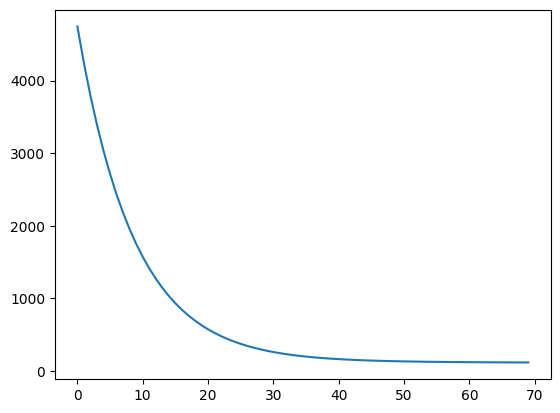

In [43]:
plt.plot(MSE_list)
plt.show()

In [44]:
print(w)

[[27.81643545]
 [16.41074612]
 [14.5128276 ]
 [12.56474248]
 [11.8488184 ]
 [12.96813717]
 [13.04292168]
 [12.92968469]]


Exercise most positively impact life expectancy. Drug consumption negatively impacts life expectancy.

In [45]:
X_life = np.genfromtxt('Data/life_expectancy_X.csv', delimiter=',')
X_life_test = np.genfromtxt('Data/life_expectancy_X_test.csv', delimiter=',')

X_life = (X_life - np.mean(X_life, axis=0)) / np.std(X_life, axis=0)
X_life_test = (X_life_test - np.mean(X_life, axis=0)) / np.std(X_life, axis=0)

cov = (1 / X_life.shape[0]) * X_life.T @ X_life
λ, v = np.linalg.eigh(cov)

W = np.hstack((v[-1].reshape(-1, 1), v[-2].reshape(-1, 1), v[-3].reshape(-1, 1), v[-4].reshape(-1, 1)))

X_life_PCA = X_life @ W
X_life_PCA_test = X_life_test @ W

scaler = MinMaxScaler()
scaler.fit(X_life_PCA)
X_life_PCA = scaler.transform(X_life_PCA)
X_life_PCA_test = scaler.transform(X_life_PCA_test)

X_life_PCA = np.hstack([np.ones((X_life_PCA.shape[0], 1)), X_life_PCA])
X_life_PCA_test = np.hstack([np.ones((X_life_PCA_test.shape[0], 1)), X_life_PCA_test])

print(X_life_PCA.shape)
print(X_life_PCA_test.shape)

(1000, 5)
(200, 5)


In [46]:
def MSE(y_hat, y):
    return (1 / len(y)) * np.sum((y_hat - y)**2)

MSE_list = []
w = np.ones((X_life_PCA.shape[1], 1)).reshape(-1, 1)
for _ in range(2500):
    w = w - 0.01 * (2/X_life_PCA.shape[0]) * X_life_PCA.T @ (X_life_PCA @ w - Y_life)
    MSE_list.append(MSE(X_life_PCA_test @ w, Y_life_test))

print(f'Final MSE: {MSE_list[-1]}')

Final MSE: 248.79345394697947


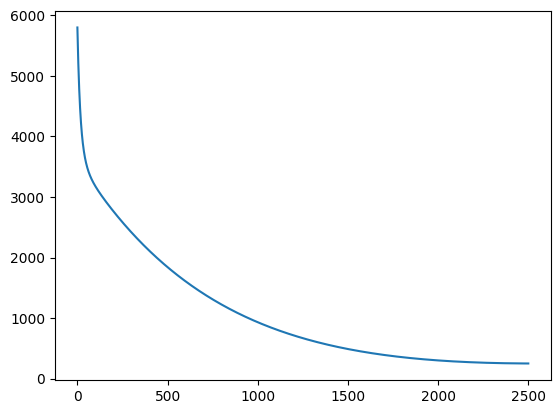

In [47]:
plt.plot(MSE_list)
plt.show()

In [48]:
w

array([[ 64.38433903],
       [-22.04392828],
       [ 18.92445727],
       [ 13.2791739 ],
       [ 16.64382204]])

Using PCA is tricky because interpreting the weights becomes much less straightforward. Before PCA, we could associate each weight value with a feature that we recorded in our data. Now that we have reduced the number of dimensions in our data, each weight vector no longer directly associates with a feature.

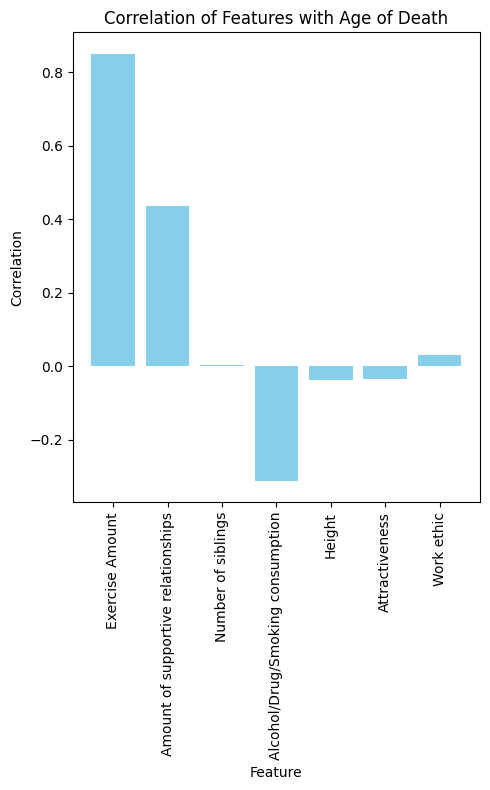

In [49]:
X = pd.read_csv("Data/life_expectancy_X.csv")
y = pd.read_csv("Data/life_expectancy_y.csv")

X['age_of_death'] = y

correlation_matrix = X.corr()
correlations = correlation_matrix['age_of_death'].drop('age_of_death')

corr_df = correlations.reset_index()
corr_df.columns = ['Feature', 'Correlation']

features = ['Exercise Amount', 'Amount of supportive relationships', 'Number of siblings', 'Alcohol/Drug/Smoking consumption',
            'Height', 'Attractiveness', 'Work ethic']
plt.figure(figsize=(5, 8))
plt.bar(features, corr_df['Correlation'], color='skyblue')
plt.title("Correlation of Features with Age of Death")
plt.xlabel("Feature")
plt.ylabel("Correlation")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

For PCA, it is hard to determine whether the correlated features match up with the PCA weights after gradient descent because we are not sure which PCA features relate to the features of our dataset. For the LASSO objective gradient descent, the values do match with the correlated features. Exercise amount is the highest, and drug consumption is the lowest.

# Question 2


Test Accuracy: 97.00%


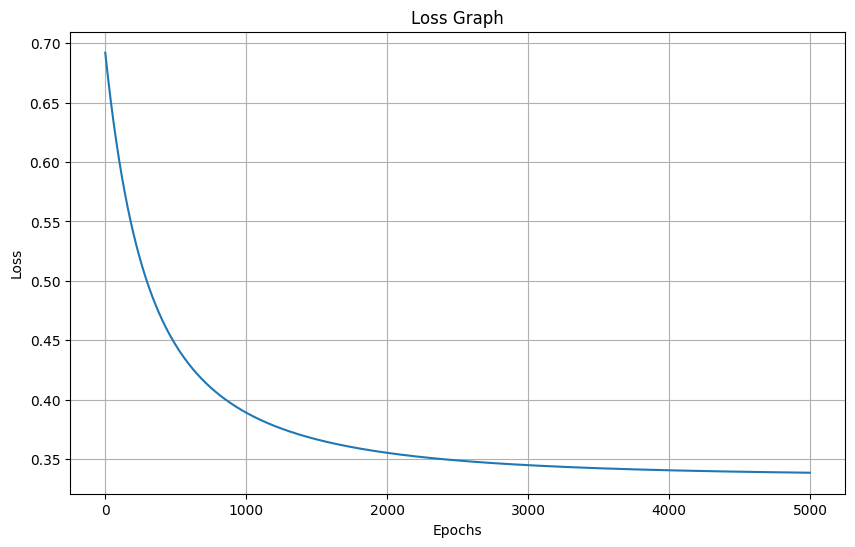


Feature Weights:
Bias: 0.6315
Exercise amount: 0.0000
Supportive relationships: 1.2177
Number of siblings: 0.0000
Alcohol/Drugs/Smoking consumption: -7.4208
Height: 0.0000
Attractiveness: 0.0000
Work ethics: 4.8734


In [50]:
X_train = np.loadtxt('Data/gpa_prediction_X.csv', delimiter=',')
y_train = np.loadtxt('Data/gpa_prediction_y.csv', delimiter=',')
X_test = np.loadtxt('Data/gpa_prediction_X_test.csv', delimiter=',')
y_test = np.loadtxt('Data/gpa_prediction_y_test.csv', delimiter=',')

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = np.hstack((np.ones((X_train_scaled.shape[0], 1)), X_train_scaled))
X_test_scaled = np.hstack((np.ones((X_test_scaled.shape[0], 1)), X_test_scaled))

def sigmoid(z):
    z = np.clip(z, -20, 20)
    return 1 / (1 + np.exp(-z))

def cost_function(X, y, w, lambda_):
    m = len(y)
    z = X @ w
    h = sigmoid(z)
    epsilon = 1e-15
    h = np.clip(h, epsilon, 1 - epsilon)
    log_loss = -1/m * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
    l1_term = lambda_ * np.sum(np.abs(w[1:]))
    return log_loss + l1_term

def gradient(X, y, w, lambda_):
    m = len(y)
    h = sigmoid(X @ w)
    gradient_log_loss = 1/m * X.T @ (h - y)

    gradient_l1 = np.zeros_like(w)
    for j in range(1, len(w)):
        if w[j] > 0:
            gradient_l1[j] = lambda_
        elif w[j] < 0:
            gradient_l1[j] = -lambda_
    
    return gradient_log_loss + gradient_l1

def gradient_descent(X, y, learning_rate=0.01, lambda_=0.1, max_iterations=5000, tol=1e-6):
    m, n = X.shape
    w = np.zeros(n)
    cost_history = []
    for _ in range(max_iterations):
        h = sigmoid(X @ w)
        grad_loss = 1/m * X.T @ (h - y)
        w_temp = w - learning_rate * grad_loss
        for j in range(1, n):
            if w_temp[j] > learning_rate * lambda_:
                w[j] = w_temp[j] - learning_rate * lambda_
            elif w_temp[j] < -learning_rate * lambda_:
                w[j] = w_temp[j] + learning_rate * lambda_
            else:
                w[j] = 0
        w[0] = w_temp[0]
        cost = cost_function(X, y, w, lambda_)
        cost_history.append(cost)
    return w, cost_history

def predict(X, w):
    h = sigmoid(X @ w)
    return (h >= 0.5).astype(int)

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred) * 100

lambda_ = 0.01
learning_rate = 0.1
w, cost_history = gradient_descent(X_train_scaled, y_train, learning_rate=learning_rate, 
                                            lambda_=lambda_, max_iterations=5000)

y_pred = predict(X_test_scaled, w)

test_accuracy = accuracy(y_test, y_pred)
print(f"\nTest Accuracy: {test_accuracy:.2f}%")

plt.figure(figsize=(10, 6))
plt.plot(cost_history)
plt.title('Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

feature_names = ['Bias', 'Exercise amount', 'Supportive relationships', 'Number of siblings', 
                 'Alcohol/Drugs/Smoking consumption', 'Height', 'Attractiveness', 'Work ethics']

print("\nFeature Weights:")
for i, (name, weight) in enumerate(zip(feature_names, w)):
    print(f"{name}: {weight:.4f}")

Work ethic most positively impacts grades. Supportive relationships mildly impacts grades. Drug use negatively impacts grades.

In [51]:
def lda_transform(X_train, y_train, X_test, n_components=1):
    n_samples, n_features = X_train.shape
    class_labels = np.unique(y_train)
    mean_overall = np.mean(X_train, axis=0)
    mean_vectors = []
    for label in class_labels:
        mean_vectors.append(np.mean(X_train[y_train == label], axis=0))
    
    Sw = np.zeros((n_features, n_features))
    for idx, label in enumerate(class_labels):
        class_data = X_train[y_train == label]
        class_mean = mean_vectors[idx]
        for sample in class_data:
            diff = (sample - class_mean).reshape(n_features, 1)
            Sw += np.dot(diff, diff.T)
    
    Sb = np.zeros((n_features, n_features))
    for idx, mean_vec in enumerate(mean_vectors):
        n_class_samples = X_train[y_train == class_labels[idx]].shape[0]
        mean_diff = (mean_vec - mean_overall).reshape(n_features, 1)
        Sb += n_class_samples * np.dot(mean_diff, mean_diff.T)

    try:
        Sw_inv = np.linalg.inv(Sw)
    except np.linalg.LinAlgError:
        Sw_inv = np.linalg.pinv(Sw)
    
    eigen_vals, eigen_vecs = np.linalg.eig(np.dot(Sw_inv, Sb))
    eigen_vals = np.real(eigen_vals)
    eigen_vecs = np.real(eigen_vecs)
    eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
    eigen_pairs.sort(key=lambda k: k[0], reverse=True)
    linear_discriminants = np.zeros((n_features, n_components))
    for i in range(n_components):
        linear_discriminants[:,i] = eigen_pairs[i][1]
    
    X_train_lda = np.dot(X_train, linear_discriminants)
    X_test_lda = np.dot(X_test, linear_discriminants)
    
    return X_train_lda, X_test_lda, linear_discriminants

def logistic_regression(X_train, y_train, X_test, learning_rate=0.01, max_iter=1000):
    X_train_bias = np.c_[np.ones((X_train.shape[0], 1)), X_train]
    X_test_bias = np.c_[np.ones((X_test.shape[0], 1)), X_test]
    weights = np.zeros(X_train_bias.shape[1])
    for _ in range(max_iter):
        z = np.dot(X_train_bias, weights)
        predictions = sigmoid(z)
        errors = y_train - predictions
        gradient = np.dot(X_train_bias.T, errors) / X_train_bias.shape[0]
        weights += learning_rate * gradient
    z_test = np.dot(X_test_bias, weights)
    y_pred = (sigmoid(z_test) >= 0.5).astype(int)
    
    return y_pred, weights

X_train_lda, X_test_lda, lda_weights = lda_transform(X_train_scaled, y_train, X_test_scaled, n_components=1)

y_pred, logreg_weights = logistic_regression(X_train_lda, y_train, X_test_lda, learning_rate=0.1, max_iter=1000)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nClassification accuracy on test set: {accuracy*100:.2f}%")
print()

lda_weights_flat = lda_weights.flatten()
print("LDA weights:")
for i, weight in enumerate(lda_weights_flat):
    print(f"{feature_names[i]}: {-weight:.4f}")


Classification accuracy on test set: 96.00%

LDA weights:
Bias: -0.0000
Exercise amount: 0.0098
Supportive relationships: 0.1908
Number of siblings: -0.0020
Alcohol/Drugs/Smoking consumption: -0.8357
Height: -0.0024
Attractiveness: 0.0017
Work ethics: 0.5149


The results between the normal logistic regression and logistic regression with LDA are very similar. Work ethic is still the most important positive feature impacting grades, with support relationship having some impact. Drug consumption is negatively impacting both too. Exercise, siblings, height, and attractiveness don't have much of an effect on grades in both models.

# Question 3

Normalized Mutual Information for K-means: 1.0000
Normalized Mutual Information for Hierarchical clustering: 1.0000


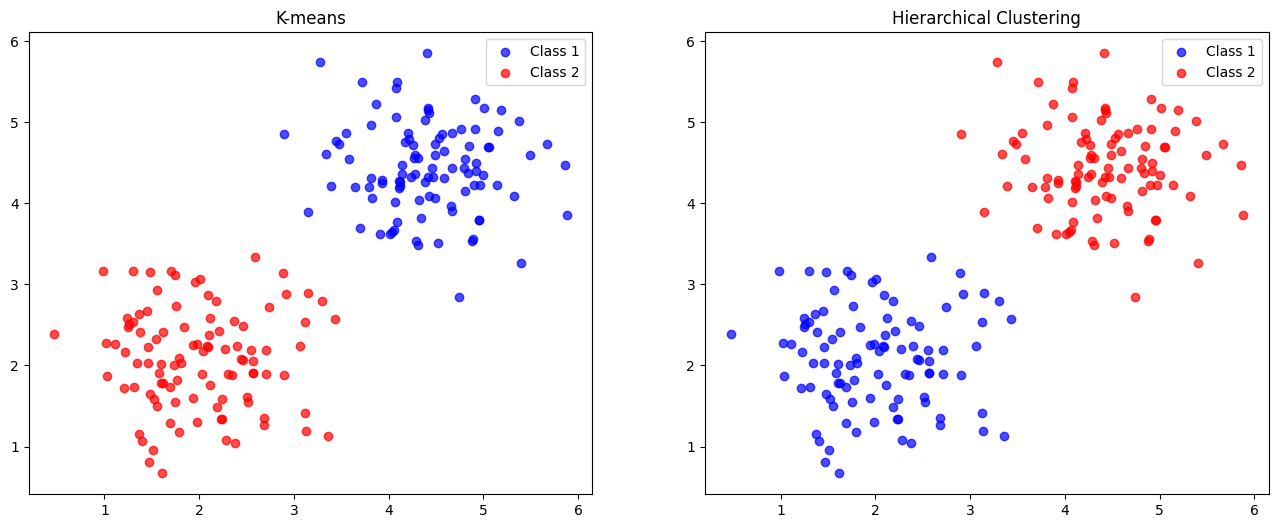

In [52]:
clustering_data = np.genfromtxt('Data/final_clustering.csv', delimiter=',')
true_labels = np.genfromtxt('Data/final_clustering_solution.csv', delimiter=',')

def kmeans(data, k, max_iterations=100):
    n_samples, n_features = data.shape
    indices = np.random.choice(n_samples, k, replace=False)
    centroids = data[indices]
    labels = np.zeros(n_samples, dtype=int)
    old_labels = np.ones(n_samples, dtype=int) * -1

    iteration = 0
    while not np.array_equal(labels, old_labels) and iteration < max_iterations:
        old_labels = labels.copy()
        for i in range(n_samples):
            distances = np.sqrt(np.sum((centroids - data[i])**2, axis=1))
            labels[i] = np.argmin(distances)
        for j in range(k):
            if np.any(labels == j):
                centroids[j] = np.mean(data[labels == j], axis=0)
        iteration += 1
    return labels + 1

def hierarchical_clustering(data, k):
    n_samples = data.shape[0]
    clusters = [[i] for i in range(n_samples)]
    distances = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(i+1, n_samples):
            dist = np.sqrt(np.sum((data[i] - data[j])**2))
            distances[i, j] = distances[j, i] = dist
    while len(clusters) > k:
        min_dist = float('inf')
        merge_i, merge_j = 0, 0
        for i in range(len(clusters)):
            for j in range(i+1, len(clusters)):
                cluster_dists = []
                for idx_i in clusters[i]:
                    for idx_j in clusters[j]:
                        cluster_dists.append(distances[idx_i, idx_j])
                dist = min(cluster_dists)
                if dist < min_dist:
                    min_dist = dist
                    merge_i, merge_j = i, j
        clusters[merge_i].extend(clusters[merge_j])
        clusters.pop(merge_j)
    labels = np.zeros(n_samples, dtype=int)
    for i, cluster in enumerate(clusters):
        for idx in cluster:
            labels[idx] = i + 1
    return labels

kmeans_labels = kmeans(clustering_data, 2)
hierarchical_labels = hierarchical_clustering(clustering_data, 2)
kmeans_nmi = normalized_mutual_info_score(true_labels, kmeans_labels)
hierarchical_nmi = normalized_mutual_info_score(true_labels, hierarchical_labels)
print(f"Normalized Mutual Information for K-means: {kmeans_nmi:.4f}")
print(f"Normalized Mutual Information for Hierarchical clustering: {hierarchical_nmi:.4f}")

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
for label in [1, 2]:
    mask = kmeans_labels == label
    color = 'blue' if label == 1 else 'red'
    plt.scatter(clustering_data[mask, 0], clustering_data[mask, 1], 
                color=color, alpha=0.7, label=f'Class {label}')
plt.title(f'K-means')
plt.legend()

plt.subplot(1, 2, 2)
for label in [1, 2]:
    mask = hierarchical_labels == label
    color = 'blue' if label == 1 else 'red'
    plt.scatter(clustering_data[mask, 0], clustering_data[mask, 1], 
                color=color, alpha=0.7, label=f'Class {label}')
plt.title(f'Hierarchical Clustering')
plt.legend()
plt.show()

# Question 4

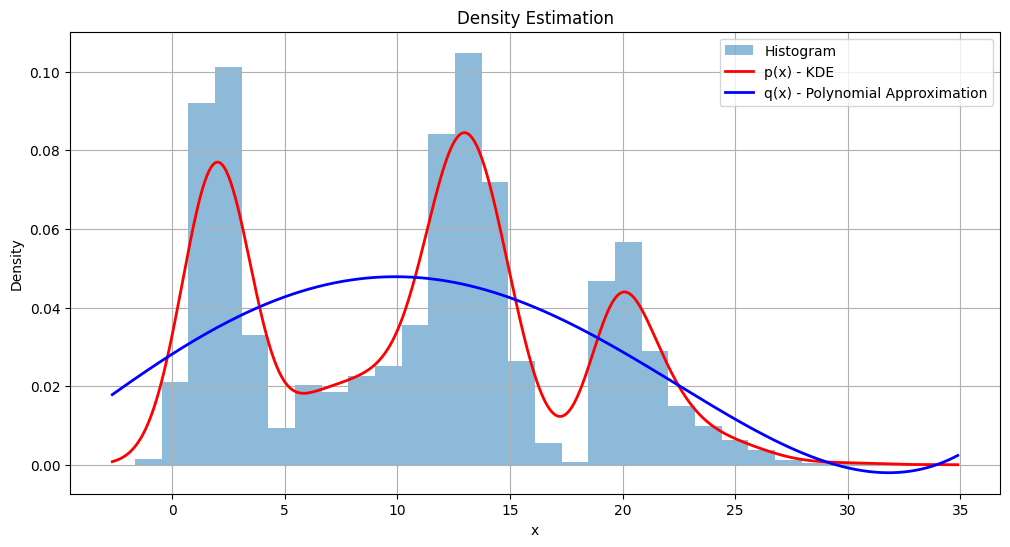

In [53]:
def kde(data, x_eval, bandwidth=None):
    n = len(data)
    if bandwidth is None:
        bandwidth = 1.06 * np.std(data) * n**(-1/5)
    densities = np.zeros_like(x_eval, dtype=float)
    def gaussian_kernel(x):
        return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x**2)
    for i, x in enumerate(x_eval):
        normalized_dists = (x - data) / bandwidth
        kernel_values = gaussian_kernel(normalized_dists)
        densities[i] = np.sum(kernel_values) / (n * bandwidth)
    return densities

data = pd.read_csv('Data/parental_anxiety_vs_kids_age.csv').values.flatten()
x_min, x_max = min(data), max(data)
x_grid = np.linspace(x_min - 1, x_max + 1, 1000)
kde_values = kde(data, x_grid)
x_samples = np.random.uniform(x_min - 1, x_max + 1, 1000)
y_samples = kde(data, x_samples)
best_degree = 0
best_mse = float('inf')
best_coefs = None
    
X_poly = np.column_stack([x_samples**i for i in range(5)])
coefs = np.linalg.pinv(X_poly.T @ X_poly) @ X_poly.T @ y_samples
y_pred = np.sum([coefs[i] * x_samples**i for i in range(5)], axis=0)
mse = np.mean((y_pred - y_samples)**2)
def q(x):
    return np.sum([coefs[i] * x**i for i in range(5)], axis=0)

plt.figure(figsize=(12, 6))
plt.hist(data, bins=30, density=True, alpha=0.5, label='Histogram')
plt.plot(x_grid, kde_values, color='red', linewidth=2, label='p(x) - KDE')
q_values = q(x_grid)
plt.plot(x_grid, q_values, color='blue', linewidth=2, label='q(x) - Polynomial Approximation')
    
plt.title('Density Estimation')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

# Question 5

Subset size = 200, KL divergence (numeric) = 0.127681, KL divergence (quad) = 0.123347
Subset size = 400, KL divergence (numeric) = 0.022810, KL divergence (quad) = 0.018028
Subset size = 600, KL divergence (numeric) = 0.022393, KL divergence (quad) = 0.017334
Subset size = 800, KL divergence (numeric) = 0.018263, KL divergence (quad) = 0.012992
Subset size = 1000, KL divergence (numeric) = 0.009988, KL divergence (quad) = 0.008553
Subset size = 1200, KL divergence (numeric) = 0.007515, KL divergence (quad) = 0.006136
Subset size = 1400, KL divergence (numeric) = 0.006953, KL divergence (quad) = 0.005934
Subset size = 1600, KL divergence (numeric) = 0.005741, KL divergence (quad) = 0.004704
Subset size = 1800, KL divergence (numeric) = 0.004525, KL divergence (quad) = 0.003473
Subset size = 2000, KL divergence (numeric) = 0.005303, KL divergence (quad) = 0.004238
Subset size = 2200, KL divergence (numeric) = 0.005196, KL divergence (quad) = 0.004125
Subset size = 2400, KL divergence (n

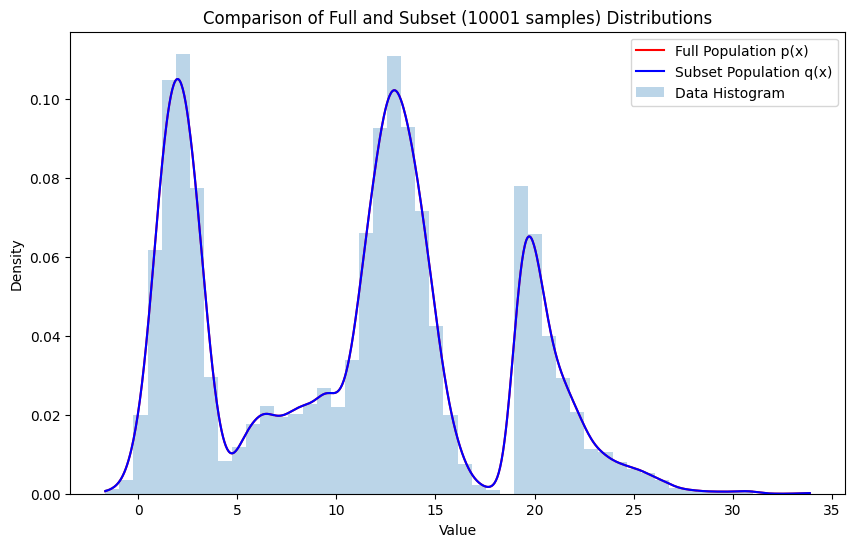

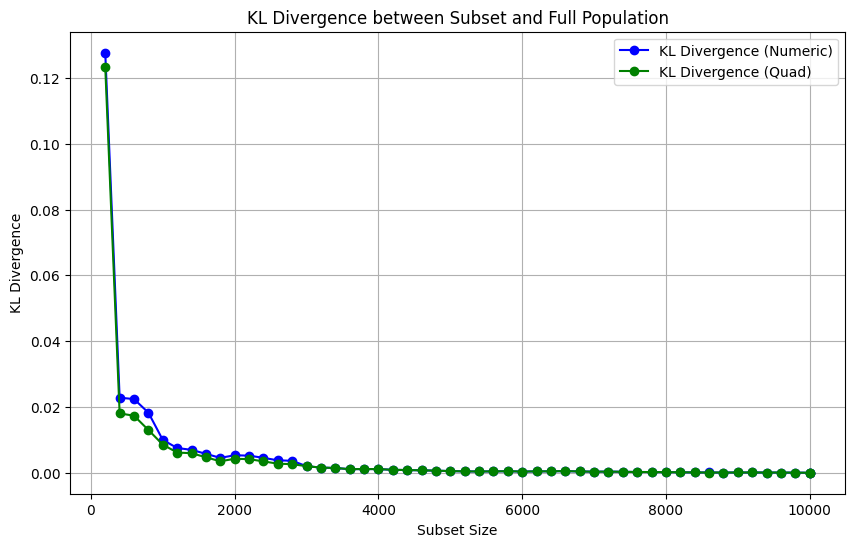

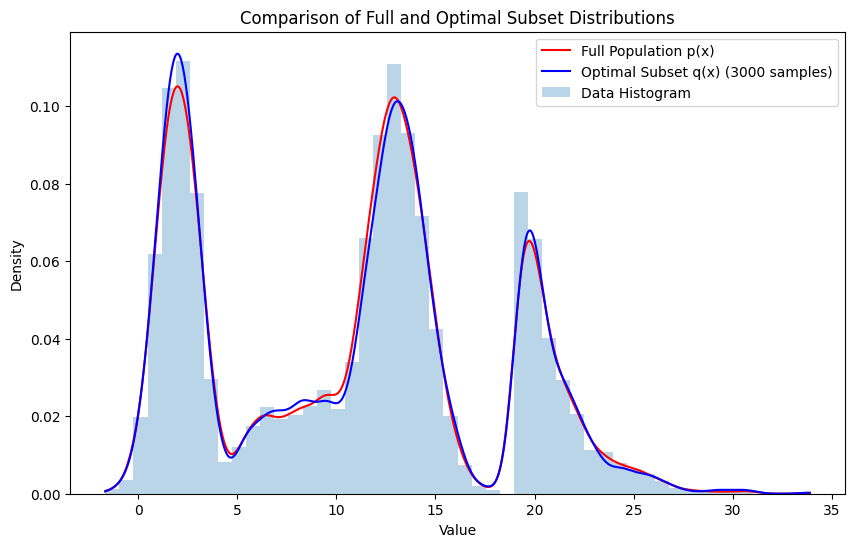

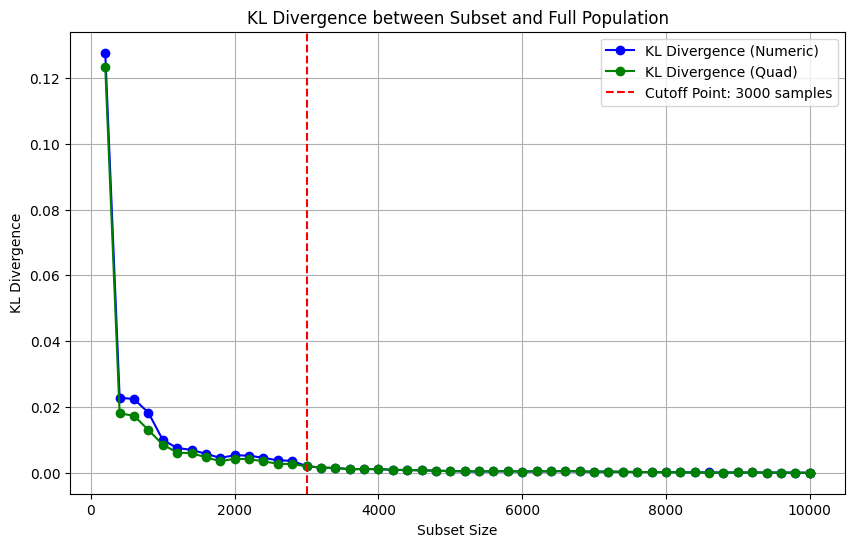

In [4]:
data = np.loadtxt('Data/parental_anxiety_vs_kids_age.csv')
bandwidth = 0.5
kde_full = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(data.reshape(-1, 1))
x_grid = np.linspace(min(data), max(data), 1000).reshape(-1, 1)
log_dens_full = kde_full.score_samples(x_grid)
dens_full = np.exp(log_dens_full)

n_iterations = int(np.ceil(len(data) / 200))
kl_divergences_numeric = []
kl_divergences_quad = []
subset_sizes = []
epsilon = 1e-10
def kl_integrand(x, p_func, q_func):
    p = p_func(x)
    q = q_func(x)
    if p < epsilon or q < epsilon:
        return 0
    return p * np.log(p / q)
for i in range(1, n_iterations + 1):
    subset_size = min(i * 200, len(data))
    subset = data[:subset_size]
    subset_sizes.append(subset_size)
    kde_subset = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(subset.reshape(-1, 1))
    log_dens_subset = kde_subset.score_samples(x_grid)
    dens_subset = np.exp(log_dens_subset)
    dens_full_safe = np.maximum(dens_full, epsilon)
    dens_subset_safe = np.maximum(dens_subset, epsilon)
    kl_pointwise = dens_full_safe * np.log(dens_full_safe / dens_subset_safe)
    dx = x_grid[1, 0] - x_grid[0, 0]
    kl_divergence_numeric = np.sum(kl_pointwise) * dx
    kl_divergences_numeric.append(kl_divergence_numeric)

    def p_density(x_scalar):
        x_arr = np.array([[x_scalar]])
        log_p = kde_full.score_samples(x_arr)
        return np.exp(log_p)[0]
    
    def q_density(x_scalar):
        x_arr = np.array([[x_scalar]])
        log_q = kde_subset.score_samples(x_arr)
        return np.exp(log_q)[0]

    kl_func = lambda x: kl_integrand(x, p_density, q_density)
    kl_divergence_quad, _ = quad(kl_func, float(min(data)), float(max(data)), limit=100)
    kl_divergences_quad.append(kl_divergence_quad)
    
    print(f"Subset size = {subset_size}, KL divergence (numeric) = {kl_divergence_numeric:.6f}, "
          f"KL divergence (quad) = {kl_divergence_quad:.6f}")

    if i == n_iterations:
        plt.figure(figsize=(10, 6))
        plt.plot(x_grid, dens_full, 'r-', label='Full Population p(x)')
        plt.plot(x_grid, dens_subset, 'b-', label='Subset Population q(x)')
        plt.hist(data, bins=50, density=True, alpha=0.3, label='Data Histogram')
        plt.title(f'Comparison of Full and Subset ({subset_size} samples) Distributions')
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.legend()
        plt.show()

plt.figure(figsize=(10, 6))
plt.plot(subset_sizes, kl_divergences_numeric, 'b-o', label='KL Divergence (Numeric)')
plt.plot(subset_sizes, kl_divergences_quad, 'g-o', label='KL Divergence (Quad)')
plt.title('KL Divergence between Subset and Full Population')
plt.xlabel('Subset Size')
plt.ylabel('KL Divergence')
plt.grid(True)
plt.legend()
plt.show()

optimal_subset_size = 3000
optimal_subset = data[:optimal_subset_size]
kde_optimal = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(optimal_subset.reshape(-1, 1))
log_dens_optimal = kde_optimal.score_samples(x_grid)
dens_optimal = np.exp(log_dens_optimal)

plt.figure(figsize=(10, 6))
plt.plot(x_grid, dens_full, 'r-', label='Full Population p(x)')
plt.plot(x_grid, dens_optimal, 'b-', label=f'Optimal Subset q(x) ({optimal_subset_size} samples)')
plt.hist(data, bins=50, density=True, alpha=0.3, label='Data Histogram')
plt.title('Comparison of Full and Optimal Subset Distributions')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(subset_sizes, kl_divergences_numeric, 'b-o', label='KL Divergence (Numeric)')
plt.plot(subset_sizes, kl_divergences_quad, 'g-o', label='KL Divergence (Quad)')
plt.axvline(x=optimal_subset_size, color='r', linestyle='--', label=f'Cutoff Point: {optimal_subset_size} samples')
plt.title('KL Divergence between Subset and Full Population')
plt.xlabel('Subset Size')
plt.ylabel('KL Divergence')
plt.grid(True)
plt.legend()
plt.show()

# Question 6

PCA


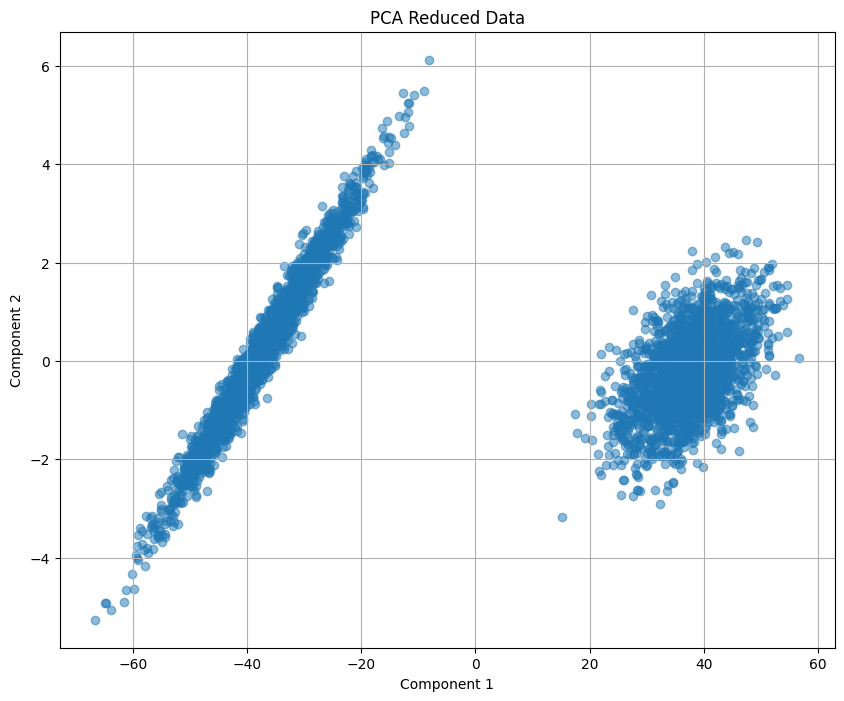

There are two distinct groupings in this PCA reduced plot

TSNE


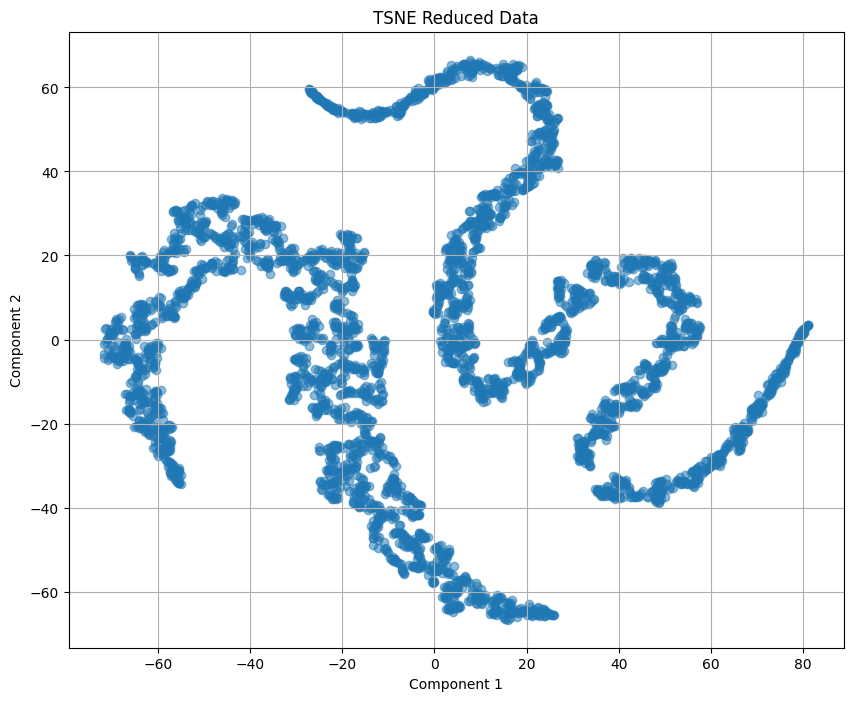

PCA Groups


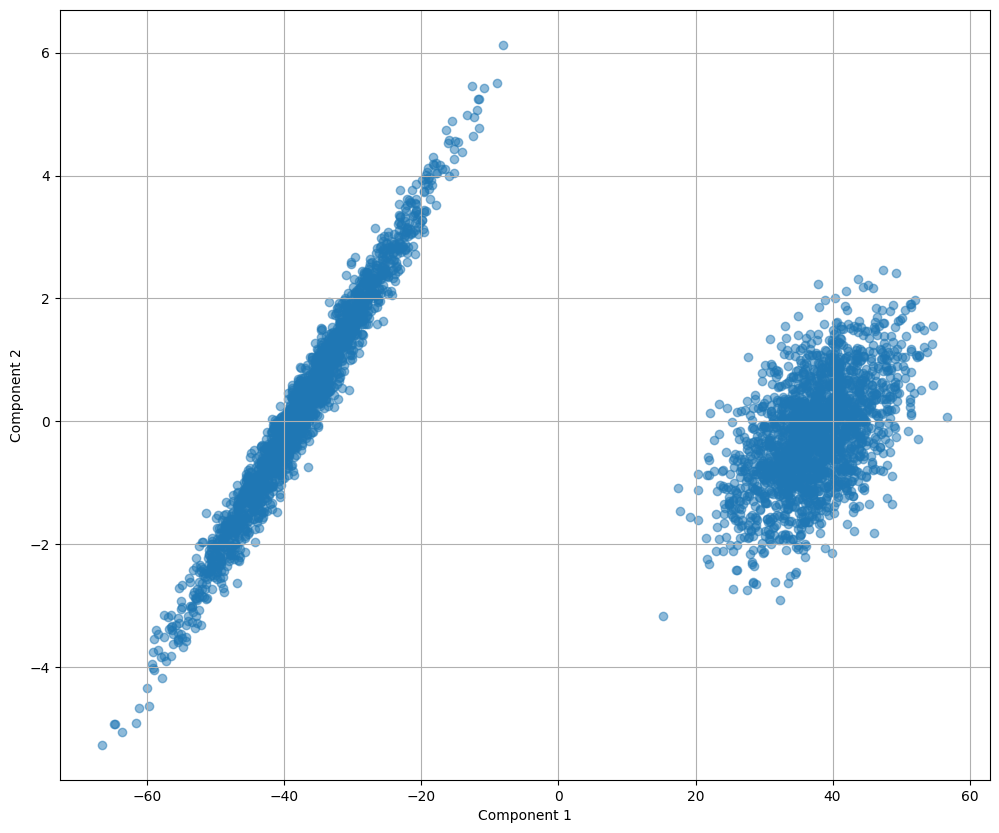

Variation of group 1: 78.56977193793608
Variation of group 2: 37.09984460451004


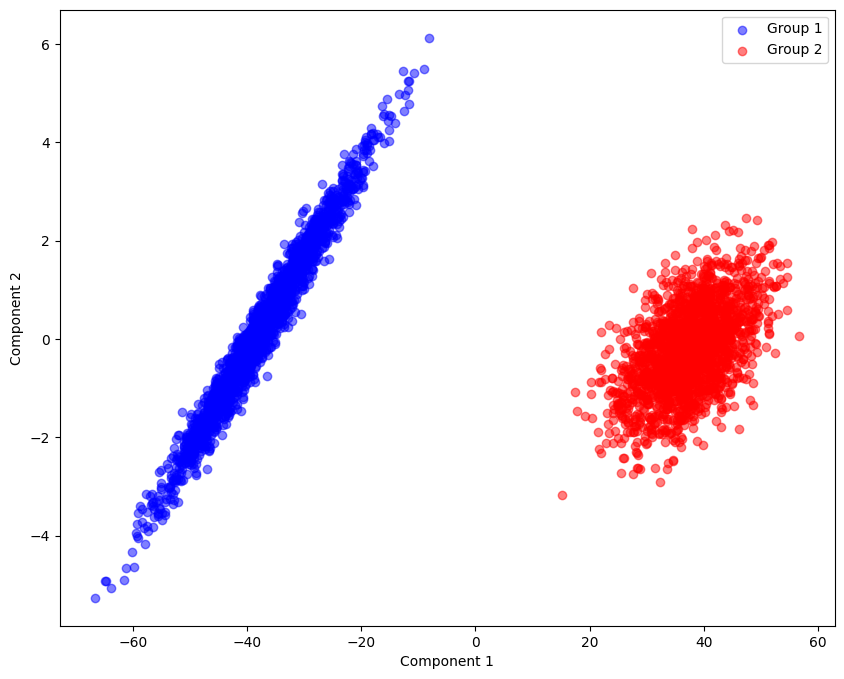


Logistic Regression
Logistic Regression Test Accuracy: 1.0000

SVM
SVM Test Accuracy: 1.0000
Both were 100% accurate

KMeans
Normalized Mutual Information between my algorithm and K-means: 1.0000


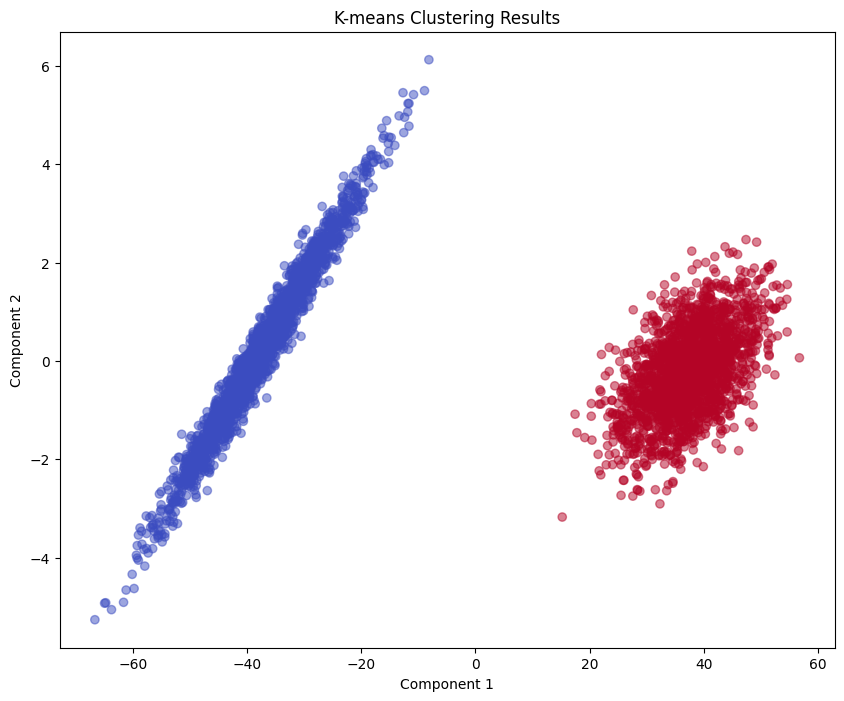

In [89]:
def load_data(filepath):
    return np.loadtxt(filepath, delimiter=',')

def pca(X):
    X_centered = X - np.mean(X, axis=0)
    cov_matrix = np.cov(X_centered, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
    n_components = max(n_components, 2)
    principal_components = eigenvectors[:, :n_components]
    X_pca = X_centered.dot(principal_components)
    return X_pca, eigenvalues, eigenvectors, n_components

def visualize_reduced_data(X_reduced, title):
    plt.figure(figsize=(10, 8))
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], alpha=0.5)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title(title)
    plt.grid(True)
    plt.show()
    return X_reduced

def analyze_groups(X_reduced, method='visual'):
    plt.figure(figsize=(12, 10))
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], alpha=0.5)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()
    if X_reduced.shape[1] >= 2:
        median_x = np.median(X_reduced[:, 0])
        labels = np.zeros(X_reduced.shape[0])
        labels[X_reduced[:, 0] > median_x] = 1
    else:
        median = np.median(X_reduced[:, 0])
        labels = np.zeros(X_reduced.shape[0])
        labels[X_reduced[:, 0] > median] = 1
    group1_indices = labels == 0
    group2_indices = labels == 1
    cov1 = np.cov(X_reduced[group1_indices], rowvar=False)
    cov2 = np.cov(X_reduced[group2_indices], rowvar=False)
    frob_norm1 = np.linalg.norm(cov1, 'fro')
    frob_norm2 = np.linalg.norm(cov2, 'fro')
    
    print(f"Variation of group 1: {frob_norm1}")
    print(f"Variation of group 2: {frob_norm2}")
    impacted_group = 0 if frob_norm1 > frob_norm2 else 1
    plt.figure(figsize=(10, 8))
    plt.scatter(X_reduced[group1_indices, 0], X_reduced[group1_indices, 1], c='blue', alpha=0.5, label='Group 1')
    plt.scatter(X_reduced[group2_indices, 0], X_reduced[group2_indices, 1], c='red', alpha=0.5, label='Group 2')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()
    return labels, impacted_group

def logistic_regression(X, y, learning_rate=0.01, epochs=1000, reg_lambda=0.01):
    m, n = X.shape
    X_b = np.c_[np.ones((m, 1)), X]
    weights = np.zeros(n + 1)
    for epoch in range(epochs):
        z = X_b.dot(weights)
        y_pred = 1 / (1 + np.exp(-z))
        error = y_pred - y
        gradient = X_b.T.dot(error) / m + reg_lambda * weights
        gradient[0] -= reg_lambda * weights[0]
        weights -= learning_rate * gradient
    return weights

def predict_logistic(X, weights):
    m = X.shape[0]
    X_b = np.c_[np.ones((m, 1)), X]
    z = X_b.dot(weights)
    y_pred = 1 / (1 + np.exp(-z))
    return (y_pred >= 0.5).astype(int)

def evaluate_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def svm_train(X, y, learning_rate=0.01, epochs=1000, C=1.0):
    m, n = X.shape
    X_b = np.c_[np.ones((m, 1)), X]
    y_svm = 2 * y - 1
    weights = np.zeros(n + 1)
    for epoch in range(epochs):
        for i in range(m):
            condition = y_svm[i] * (np.dot(X_b[i], weights)) >= 1
            if condition:
                gradient = np.zeros_like(weights)
                gradient[1:] = weights[1:] / C
            else:
                gradient = np.zeros_like(weights)
                gradient[1:] = weights[1:] / C - y_svm[i] * X_b[i, 1:]
                gradient[0] = -y_svm[i] * X_b[i, 0]
            weights -= learning_rate * gradient
    return weights

def predict_svm(X, weights):
    m = X.shape[0]
    X_b = np.c_[np.ones((m, 1)), X]
    scores = X_b.dot(weights)
    return (scores >= 0).astype(int)

def kmeans(X, k=2, max_iters=100):
    np.random.seed(42)
    indices = np.random.permutation(X.shape[0])[:k]
    centroids = X[indices]
    for _ in range(max_iters):
        distances = np.sqrt(((X[:, np.newaxis, :] - centroids) ** 2).sum(axis=2))
        labels = np.argmin(distances, axis=1)
        new_centroids = np.array([X[labels == i].mean(axis=0) if np.sum(labels == i) > 0 else centroids[i] 
                                  for i in range(k)])
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    return labels, centroids

X = load_data('Data/Pollution_data.csv')

X_pca, eigenvalues, eigenvectors, n_components = pca(X)
print('PCA')
X_pca_2d = X_pca[:, :2]
visualize_reduced_data(X_pca_2d, 'PCA Reduced Data')
print('There are two distinct groupings in this PCA reduced plot')
print()
print('TSNE')
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)
visualize_reduced_data(X_tsne, 'TSNE Reduced Data')

print('PCA Groups')
pca_labels, pca_impacted_group = analyze_groups(X_pca_2d, method='pca')
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, pca_labels, test_size=0.2, random_state=42)
print()
print('Logistic Regression')
log_weights = logistic_regression(X_train, y_train)
log_predictions = predict_logistic(X_test, log_weights)
log_accuracy = evaluate_accuracy(y_test, log_predictions)
print(f"Logistic Regression Test Accuracy: {log_accuracy:.4f}")
print()
print('SVM')
svm_weights = svm_train(X_train, y_train)
svm_predictions = predict_svm(X_test, svm_weights)
svm_accuracy = evaluate_accuracy(y_test, svm_predictions)
print(f"SVM Test Accuracy: {svm_accuracy:.4f}")
print(f"Both were 100% accurate")
print()
print("KMeans")
kmeans_labels, _ = kmeans(X_pca)
nmi_score = normalized_mutual_info_score(pca_labels, kmeans_labels)
print(f"Normalized Mutual Information between my algorithm and K-means: {nmi_score:.4f}")
plt.figure(figsize=(10, 8))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=kmeans_labels, cmap='coolwarm', alpha=0.5)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('K-means Clustering Results')
plt.show()